In [1]:
import json
import sacrebleu
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import Levenshtein
import numpy as np
from scipy.stats import pearsonr, spearmanr

In [2]:
with open('./json/dataset_reviewed.json', 'r') as file:
    dataset = json.load(file)

In [3]:
def exact_match(actual, predicted):
    return int(actual.strip() == predicted.strip())

def chrf(actual, predicted):
    return sacrebleu.corpus_chrf([predicted], [[actual]]).score / 100

def bleu(actual, predicted):
    actual_tokens = actual.split()
    predicted_tokens = predicted.split()
    smoothing = SmoothingFunction().method1
    
    return sentence_bleu([actual_tokens], predicted_tokens, smoothing_function=smoothing)

def rouge(actual, predicted):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=False)
    scores = scorer.score(actual, predicted)
    return scores['rougeL'].fmeasure

def levenshtein(actual, predicted):
    return Levenshtein.distance(actual, predicted)

In [4]:
for data in dataset:
    actual = data['middle']
    predicted = data['middle_predicted']
    
    data['exact_match'] = exact_match(actual, predicted)
    data['chrf'] = chrf(actual, predicted)
    data['bleu'] = bleu(actual, predicted)
    data['rouge'] = rouge(actual, predicted)
    data['levenshtein'] = levenshtein(actual, predicted)

In [5]:
with open('json/dataset_metrics.json', 'w') as file:
    json.dump(dataset, file)

In [6]:
for i, data in enumerate(dataset, start=1):
    print('-' * 20)
    print(f'Example {i}')
    print('-' * 20)
    
    print(f"Review label: {data['review_label']}")
    print(f"Comment: {data['comment']}")
    print()
    
    print(f"Exact Match: {data['exact_match']}")
    print(f"CHRF Score: {data['chrf']:.2f}")
    print(f"BLEU Score: {data['bleu']:.2f}")
    print(f"ROUGE-L Score: {data['rouge']:.2f}")
    print(f"Levenshtein Distance: {data['levenshtein']}")
    
    print()

--------------------
Example 1
--------------------
Review label: 3
Comment: Last three lines are completely correct, but first three lines don't make sense in this context

Exact Match: 0
CHRF Score: 0.85
BLEU Score: 0.68
ROUGE-L Score: 0.77
Levenshtein Distance: 98

--------------------
Example 2
--------------------
Review label: 1
Comment: /

Exact Match: 0
CHRF Score: 0.36
BLEU Score: 0.01
ROUGE-L Score: 0.23
Levenshtein Distance: 486

--------------------
Example 3
--------------------
Review label: 1
Comment: /

Exact Match: 0
CHRF Score: 0.11
BLEU Score: 0.00
ROUGE-L Score: 0.03
Levenshtein Distance: 404

--------------------
Example 4
--------------------
Review label: 2
Comment: The first line matches perfectly with the actual code, but the next three lines are identical to a part of prefix code

Exact Match: 0
CHRF Score: 0.42
BLEU Score: 0.05
ROUGE-L Score: 0.22
Levenshtein Distance: 232

--------------------
Example 5
--------------------
Review label: 1
Comment: /

Exact 

In [7]:
review_labels = [int(data['review_label']) for data in dataset]
exact_match_scores = [data['exact_match'] for data in dataset]
chrf_scores = [data['chrf'] for data in dataset]
bleu_scores = [data['bleu'] for data in dataset]
rouge_scores = [data['rouge'] for data in dataset]
levenshtein_scores = [data['levenshtein'] for data in dataset]

metrics = {
    'Exact match': exact_match_scores,
    'CHRF': chrf_scores,
    'BLEU': bleu_scores,
    'ROUGE-L': rouge_scores,
    'Levenshtein': levenshtein_scores
}

for i, (metric_name, metric_scores) in enumerate(metrics.items()):
    pearson_corr, _ = pearsonr(review_labels, metric_scores)
    spearman_corr, _ = spearmanr(review_labels, metric_scores)
    
    if i != 0:
        print()
        
    print(f"{metric_name}: Pearson Correlation: {pearson_corr}")
    print(f"{metric_name}: Spearman Correlation: {spearman_corr}")

Exact match: Pearson Correlation: 0.5069270526522721
Exact match: Spearman Correlation: 0.41646952132008896

CHRF: Pearson Correlation: 0.7667403947283443
CHRF: Spearman Correlation: 0.7084996745431696

BLEU: Pearson Correlation: 0.7599475379181952
BLEU: Spearman Correlation: 0.7864677118487128

ROUGE-L: Pearson Correlation: 0.8386877839096292
ROUGE-L: Spearman Correlation: 0.6993378380873106

Levenshtein: Pearson Correlation: -0.45974165680534135
Levenshtein: Spearman Correlation: -0.4383670766237179


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

<Figure size 1500x1000 with 0 Axes>

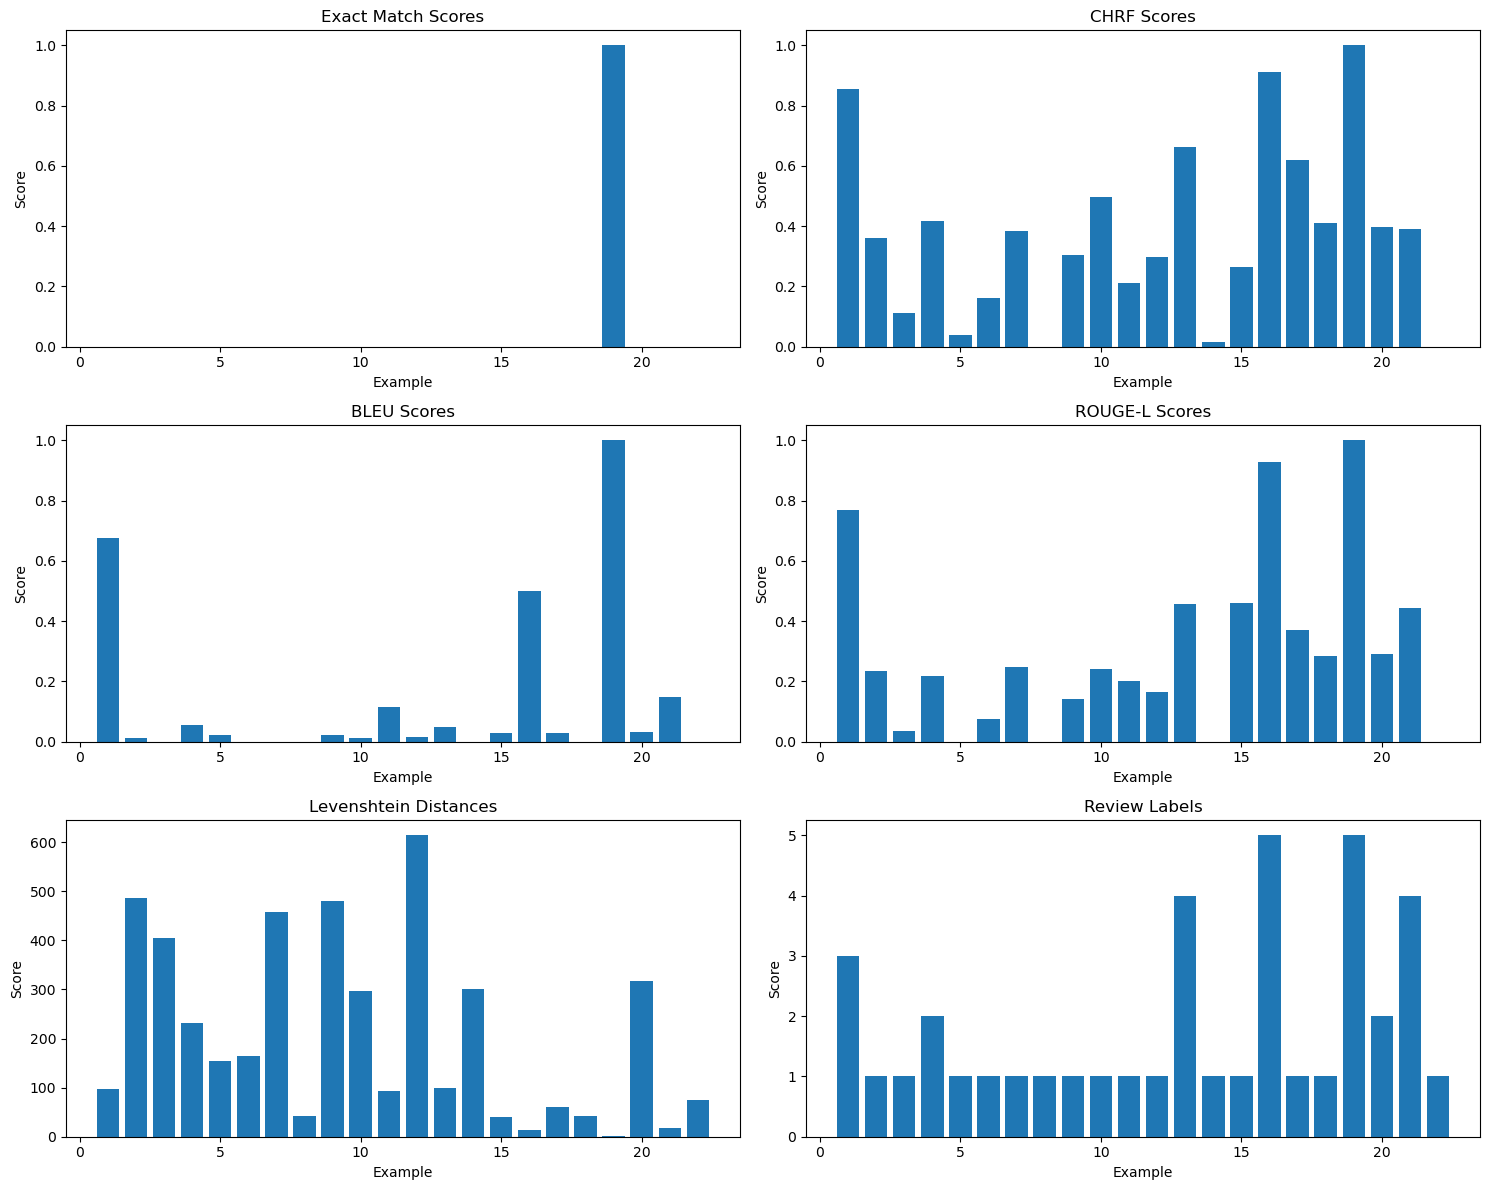

In [9]:
plt.figure(figsize=(15, 10))
x = range(1, len(dataset) + 1)

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()

axes[0].bar(x, exact_match_scores)
axes[0].set_title('Exact Match Scores')

axes[1].bar(x, chrf_scores)
axes[1].set_title('CHRF Scores')

axes[2].bar(x, bleu_scores)
axes[2].set_title('BLEU Scores')

axes[3].bar(x, rouge_scores)
axes[3].set_title('ROUGE-L Scores')

axes[4].bar(x, levenshtein_scores)
axes[4].set_title('Levenshtein Distances')

axes[5].bar(x, review_labels)
axes[5].set_title('Review Labels')

for ax in axes:
    ax.set_xlabel('Example')
    ax.set_ylabel('Score')

plt.tight_layout()
plt.show()

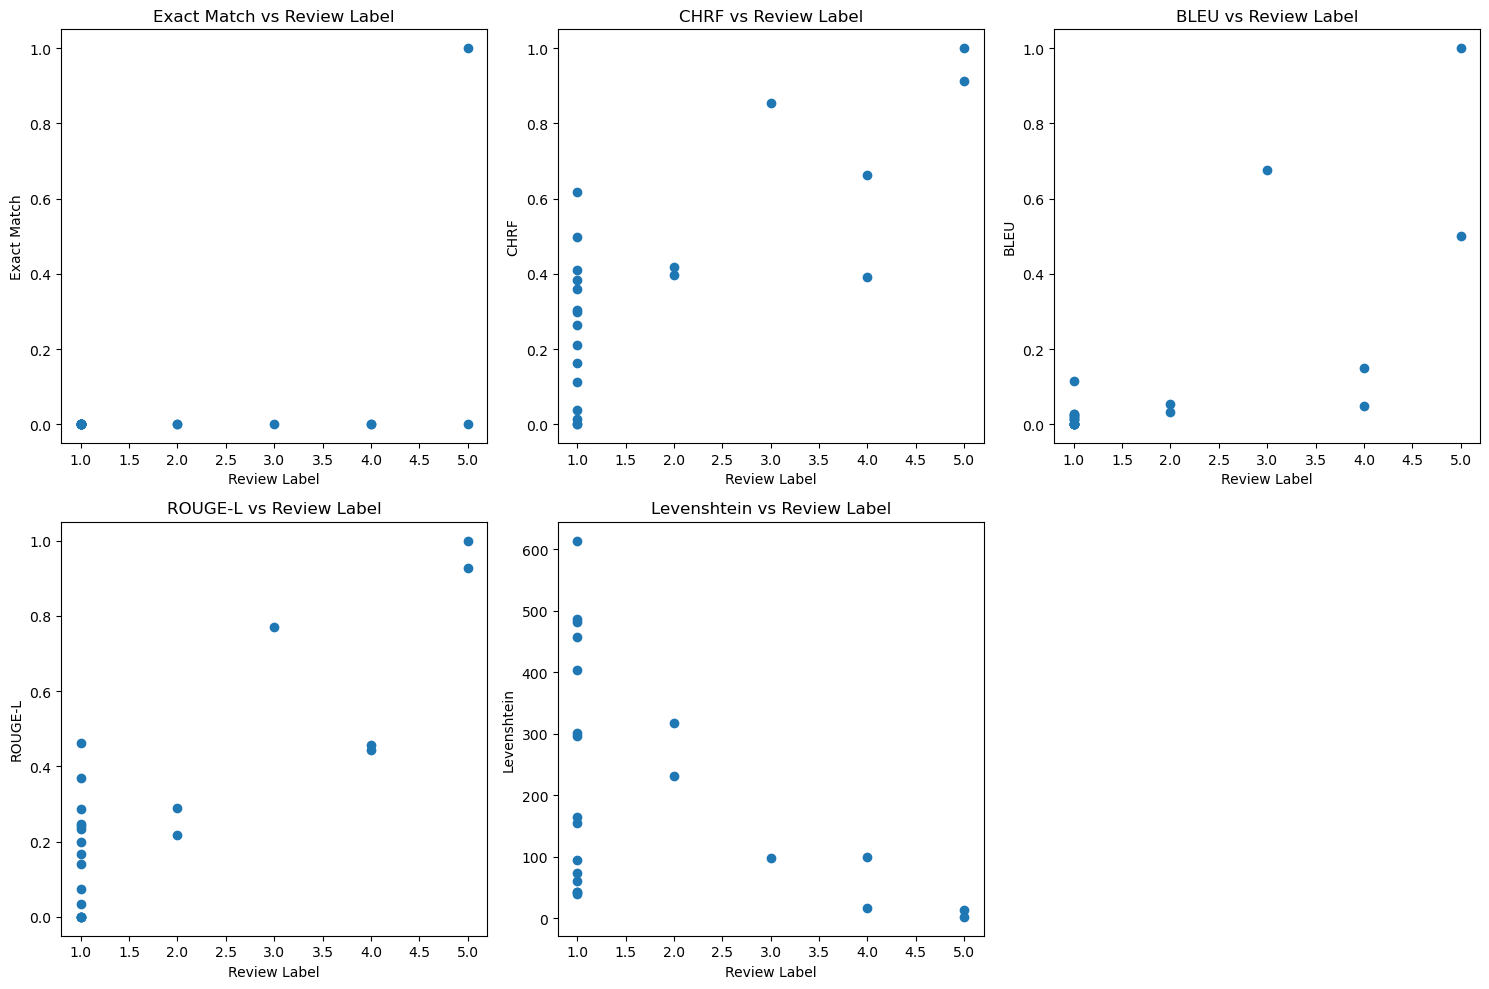

In [10]:
metrics_to_plot = {
    'Exact Match': exact_match_scores,
    'CHRF': chrf_scores,
    'BLEU': bleu_scores,
    'ROUGE-L': rouge_scores,
    'Levenshtein': levenshtein_scores
}

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (metric_name, metric_scores) in enumerate(metrics_to_plot.items()):
    axes[idx].scatter(review_labels, metric_scores)
    axes[idx].set_xlabel('Review Label')
    axes[idx].set_ylabel(metric_name)
    axes[idx].set_title(f'{metric_name} vs Review Label')

fig.delaxes(axes[5])
    
plt.tight_layout()
plt.show()

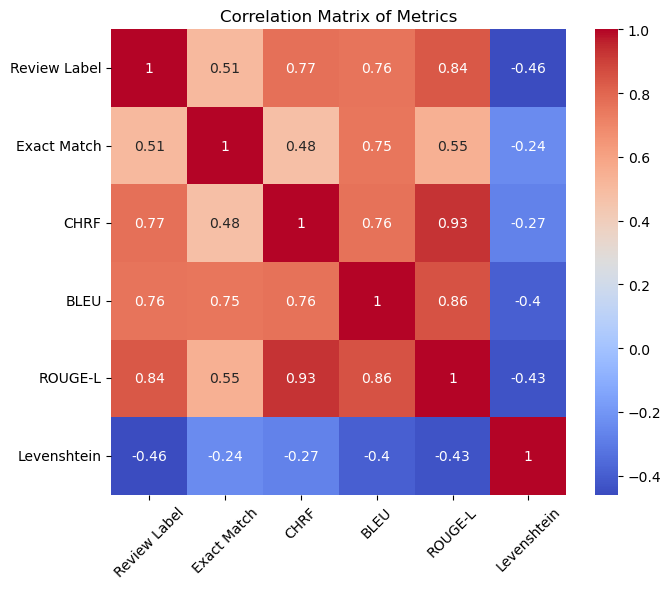

In [11]:
plt.figure(figsize=(7, 6))
correlation_data = {
    'Review Label': review_labels,
    'Exact Match': exact_match_scores,
    'CHRF': chrf_scores,
    'BLEU': bleu_scores,
    'ROUGE-L': rouge_scores,
    'Levenshtein': levenshtein_scores
}
correlation_df = pd.DataFrame(correlation_data)
sns.heatmap(correlation_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Metrics')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()